
# USD Time Series — EDA & Forecast

**Goal:** Explore and model the daily USD exchange rate to predict the next-day value.  
Dataset: `Daily.csv` (1978—2025, daily granularities; multiple currencies; we will focus on **USD**).

**Deliverables for the project:**
- EDA (quality checks, trends, seasonality, correlations)
- Feature engineering (lags, moving averages, calendar features)
- Time-aware train/test split
- Modeling (baseline + tree-based)
- Metrics (MAE, RMSE, MAPE) and forecast vs actuals
- Ideas for monitoring & drift analysis


In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


## Load & Inspect Data

In [2]:

DATA_PATH = Path("../data/Daily.csv")

# читаем данные(загружаем)
df_raw = pd.read_csv(DATA_PATH)
print(df_raw.shape)
df_raw.head()


(11626, 20)


,Date,USD,EUR,JPY,GBP,CAD,CHF,INR,CNY,TRY,SAR,IDR,AED,THB,VND,EGP,KRW,RUB,ZAR,AUD
0,12/29/1978,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1/1/1979,226.0,137.1,NaN,110.7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1/2/1979,226.8,137.3,"43,164.9",111.5,263.7,359.6,"1,792.9",NaN,NaN,735.6,"138,160.5",851.3,"4,454.6",NaN,NaN,"107,470.0",NaN,194.6,193.6
3,1/3/1979,218.6,134.0,"43,717.9",108.0,264.4,365.9,"1,802.2",NaN,NaN,739.4,"138,877.0",855.7,"4,477.7",NaN,NaN,"108,027.4",NaN,192.2,193.0
4,1/4/1979,223.2,136.8,"43,674.9",110.7,264.1,366.4,"1,811.7",NaN,NaN,743.4,"139,616.3",860.3,"4,501.5",NaN,NaN,"108,602.5",NaN,193.0,194.6


## Cleaning & Type Conversions

In [3]:

df = df_raw.copy()

# Parse dates — dataset examples look like MM/DD/YYYY
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', infer_datetime_format=True)

# Identify numeric columns (currencies) excluding Date
num_cols = [c for c in df.columns if c != 'Date']

# Remove thousands separators (',') then convert to float
for c in num_cols:
    df[c] = pd.to_numeric(df[c].astype(str).str.replace(',', ''), errors='coerce')

# Sort by date and drop duplicates
df = df.drop_duplicates(subset=['Date']).sort_values('Date').reset_index(drop=True)

# Keep only rows with at least USD present for our target
df = df[~df['USD'].isna()].copy()

print(df.dtypes)
df.describe(include='all').T


Date    datetime64[ns]
USD            float64
EUR            float64
JPY            float64
GBP            float64
CAD            float64
CHF            float64
INR            float64
CNY            float64
TRY            float64
SAR            float64
IDR            float64
AED            float64
THB            float64
VND            float64
EGP            float64
KRW            float64
RUB            float64
ZAR            float64
AUD            float64
dtype: object


,count,mean,min,25%,50%,75%,max,std
Date,11626,2001-04-10 07:11:54.054704896,1978-12-29 00:00:00,1990-02-19 06:00:00,2001-04-10 12:00:00,2012-05-30 18:00:00,2023-07-21 00:00:00,NaN
USD,11626.0,743.548667,216.9,355.7,425.8,1222.0,2067.2,519.592487
EUR,11626.0,622.438302,133.8,308.025,376.3,997.4,1863.7,439.322262
JPY,11624.0,89683.954852,26851.6,43146.7,75984.65,131559.225,279051.6,53903.509779
GBP,11626.0,494.800662,108.0,219.0,260.8,793.75,1635.0,398.16481
CAD,11624.0,911.109033,256.8,459.575,538.5,1410.125,2768.5,623.171949
CHF,11624.0,865.940408,359.6,502.275,738.1,1179.05,1894.1,402.593487
INR,11624.0,37991.445845,1782.0,6457.65,13572.5,74682.0,167324.4,42088.673087
CNY,10055.0,5260.113088,809.6,2214.1,3363.4,8307.5,14373.9,3613.820956
TRY,10581.0,3114.044391,0.1,3.0,527.1,2873.4,53214.8,7041.958762


## EDA: Missingness & Basic Statistics

In [4]:

missing_summary = df.isna().mean().sort_values(ascending=False)
missing_summary


RUB     0.314898
VND     0.245226
EGP     0.222863
CNY     0.135128
TRY     0.089885
IDR     0.000172
INR     0.000172
JPY     0.000172
AED     0.000172
SAR     0.000172
CAD     0.000172
CHF     0.000172
ZAR     0.000172
KRW     0.000172
AUD     0.000172
THB     0.000172
EUR     0.000000
USD     0.000000
Date    0.000000
GBP     0.000000
dtype: float64

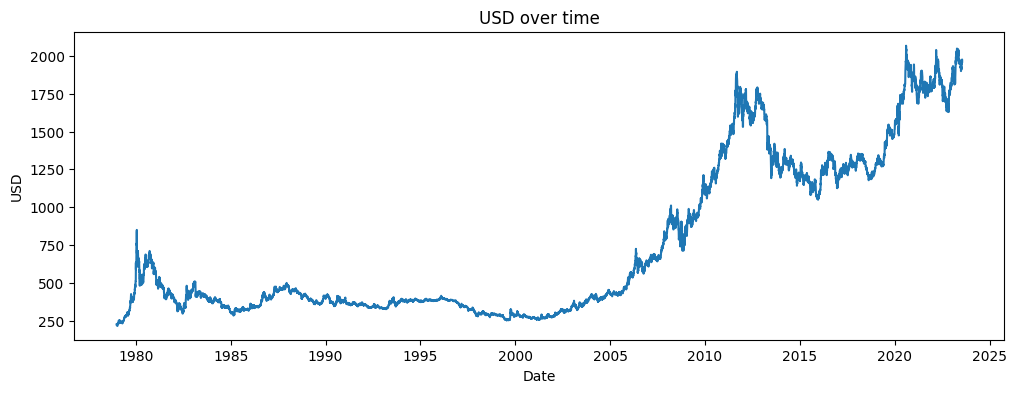

In [5]:

# Plot USD over time
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['USD'])
plt.title('USD over time')
plt.xlabel('Date')
plt.ylabel('USD')
plt.show()


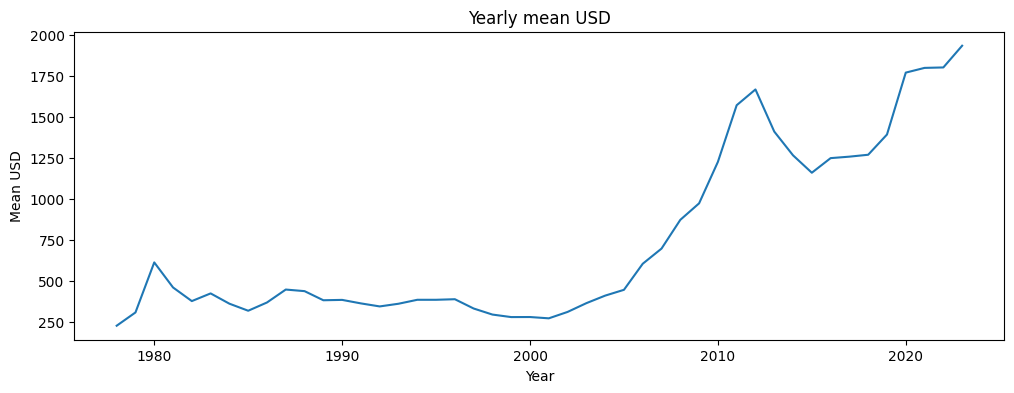

In [6]:

# Calendar features for exploratory grouping
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['dayofweek'] = df['Date'].dt.dayofweek

# Yearly overview (mean USD)
yearly = df.groupby('year', as_index=False)['USD'].mean()
plt.figure(figsize=(12,4))
plt.plot(yearly['year'], yearly['USD'])
plt.title('Yearly mean USD')
plt.xlabel('Year')
plt.ylabel('Mean USD')
plt.show()


## Seasonal Decomposition (optional)

In [7]:

try:
    from statsmodels.tsa.seasonal import seasonal_decompose
    # Ensure regular frequency
    df_ts = df.set_index('Date').asfreq('D')
    # Forward fill gaps for decomposition
    df_ts['USD'] = df_ts['USD'].ffill()
    result = seasonal_decompose(df_ts['USD'], model='additive', period=365)
    result.plot()
    plt.show()
except Exception as e:
    print('Decomposition skipped:', e)


Decomposition skipped: No module named 'statsmodels'


## Feature Engineering

In [8]:

work = df.copy()

# Lag features
for lag in [1, 3, 7, 14, 30]:
    work[f'USD_lag_{lag}'] = work['USD'].shift(lag)

# Moving averages
for win in [3, 7, 14, 30]:
    work[f'USD_ma_{win}'] = work['USD'].rolling(window=win, min_periods=1).mean()

# Calendar features already present
# Drop early rows with NaNs after lagging
work = work.dropna().reset_index(drop=True)

feature_cols = [c for c in work.columns if c not in ['USD', 'Date']]
X = work[feature_cols]
y = work['USD']

X.shape, y.shape


((7965, 30), (7965,))

## Train/Test Split (Time Aware)

In [9]:

# Use last ~3 years for test
last_date = work['Date'].max()
test_start = last_date - pd.Timedelta(days=365*3)

train_idx = work['Date'] < test_start
test_idx  = work['Date'] >= test_start

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx], y[test_idx]

print('Train range:', work.loc[train_idx, 'Date'].min(), '→', work.loc[train_idx, 'Date'].max(), len(X_train))
print('Test  range:', work.loc[test_idx, 'Date'].min(),  '→', work.loc[test_idx, 'Date'].max(),  len(X_test))


Train range: 1993-01-11 00:00:00 → 2020-07-20 00:00:00 7181
Test  range: 2020-07-21 00:00:00 → 2023-07-21 00:00:00 784


## Modeling: Baselines (Linear Regression, Random Forest)

In [10]:

models = {}

# Linear Regression
lin = LinearRegression()
lin.fit(X_train, y_train)
models['LinearRegression'] = lin

# Random Forest
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=None,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)
models['RandomForest'] = rf

# Evaluate
def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    eps = 1e-9
    return np.mean(np.abs((y_true - y_pred) / (y_true + eps))) * 100

results = []
for name, model in models.items():
    pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, pred)
    rmse = mean_squared_error(y_test, pred, squared=False)
    mp = mape(y_test, pred)
    results.append({'model': name, 'MAE': mae, 'RMSE': rmse, 'MAPE_%': mp})

res_df = pd.DataFrame(results).sort_values('RMSE')
res_df


TypeError: got an unexpected keyword argument 'squared'

## Predictions vs Actuals (Test Period)

In [ ]:

best_model_name = res_df.iloc[0]['model']
best_model = models[best_model_name]
pred = best_model.predict(X_test)

plot_df = work.loc[test_idx, ['Date', 'USD']].copy()
plot_df['Pred'] = pred

plt.figure(figsize=(12,4))
plt.plot(plot_df['Date'], plot_df['USD'], label='Actual')
plt.plot(plot_df['Date'], plot_df['Pred'], label='Predicted')
plt.title(f'USD — Actual vs Predicted ({best_model_name})')
plt.xlabel('Date')
plt.ylabel('USD')
plt.legend()
plt.show()


## One-step Ahead Forecast (Naive Demo)

In [11]:

# Take the last available row to forecast the next day
last_row = work.iloc[-1:].copy()

# Simulate next-day features
next_date = last_row['Date'].iloc[0] + pd.Timedelta(days=1)
# Recompute lag features using last known USD
# Since we already have all lags in 'last_row', we'll keep them
next_features = last_row.drop(columns=['USD', 'Date']).copy()

next_pred = best_model.predict(next_features)[0]
print('Last date:', last_row['Date'].iloc[0].date())
print('Next date (forecast):', next_date.date())
print('Forecasted USD:', float(next_pred))


NameError: name 'best_model' is not defined

## Data Drift & Stability (Optional — Evidently)

In [ ]:

try:
    from evidently.report import Report
    from evidently.metric_preset import DataDriftPreset
    ref = work[work['Date'] < work['Date'].max() - pd.Timedelta(days=365*3)].copy()
    cur = work[work['Date'] >= work['Date'].max() - pd.Timedelta(days=365*3)].copy()

    # Use features only for drift; avoid target leakage
    ref_X = ref.drop(columns=['USD', 'Date'])
    cur_X = cur.drop(columns=['USD', 'Date'])

    report = Report(metrics=[DataDriftPreset()])
    report.run(reference_data=ref_X, current_data=cur_X)
    report_path = '/mnt/data/evidently_drift_report.html'
    report.save_html(report_path)
    print('Drift report saved to:', report_path)
except Exception as e:
    print('Evidently not installed or failed:', e)



## Conclusions & Next Steps
- We explored long-term trends, seasonality and calendar effects for USD.
- Baseline models (Linear Regression, Random Forest) provide a benchmark.
- Best model (by RMSE) is plotted against the test period.
- Next steps:
  - Hyperparameter tuning (RandomizedSearchCV/GridSearchCV)
  - Try gradient boosting (XGBoost/CatBoost) or Prophet/LSTM
  - Add exogenous features (other currencies, macro indicators)
  - Integrate Evidently into a monitoring pipeline
